# 1. Libaries

In [97]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns
from sklearn.utils import shuffle

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc, classification_report, plot_confusion_matrix, precision_recall_curve, f1_score
from sklearn.metrics import precision_score, recall_score, auc, accuracy_score

In [98]:
TARGET_FEATURE = 'FLAG'

class Ethereum_Fraud_Model:
    """
        Data: 
            - https://www.kaggle.com/datasets/vagifa/ethereum-frauddetection-dataset
        
        Notes:
            We can modularize our codes into functions in the en. This is just a 
            placeholder for now.
    """
    
    def __init__(self):
        self.import_data()
        self.preprocess_data()
        self.models = []

    def import_data(self, data_name='ethereum'):
        if data_name == 'ethereum':
            self.df = pd.read_csv('./data/transaction_dataset.csv', index_col=0)
            self.df = shuffle(self.df)
            
    def preprocess_data(self):
        self.filtered_colns = ['Index', 'Address', ' ERC20 most sent token type', ' ERC20_most_rec_token_type']
        pass
    
    def add_model(self, model):
        self.models.append(model)
    
    def run_model(self, model_name):
        for model in self.models:
            if model.get_model_name().upper() == model_name.upper(): # Making it case insensitive
                model.run()
    
    def run_models(self):
        for model in self.models:
            model.run()
        

In [99]:
from sklearn.mixture import GaussianMixture

class GMM_Model():
    """
        Class for GMM Model
    """
    def __init__(self, df):
        self.df = df
        self.preprocess_data()
        self.train, self.valid, self.test = self.spilt_data_3way()
        self.model_name = 'GMM'

    def get_model_name(self):
        return self.model_name

    def preprocess_data(self):
        # QuickFix, Need to update it once data cleaning and preparation step completes
        self.df.fillna(self.df.median(), inplace=True)
        self.normal_data = self.df[self.df[TARGET_FEATURE] == 0]
        self.anomaly_data = self.df[self.df[TARGET_FEATURE] == 1]
    
    # TO-DO: Allow consumer function to split percentages
    def spilt_data_3way(self, normal_data=None, anomaly_data=None):
        if not normal_data:
            normal_data = self.normal_data
        if not anomaly_data:
            anomaly_data = self.anomaly_data
            
        # Spliting Normal data into 80% + 10% + 10%
        train, valid, test = np.split(normal_data.sample(frac=1, random_state=42), [int(.8*len(normal_data)), int(.9*len(normal_data))])
        
        # Splitting Anomaly data into 50% + 50%
        valid_anomaly, test_anomaly = np.split(anomaly_data.sample(frac=1, random_state=42), [int(.5*len(anomaly_data))])
        
        # Combining Validation data and shuffling it
        valid = pd.concat([valid, valid_anomaly]).sample(frac=1)
        
        # Combining Test Data and shuffling it
        test = pd.concat([test, test_anomaly]).sample(frac=1)
        # print('Train shape: ', train.shape)
        # print('Proportion os anomaly in training set: %.3f\n' % train[TARGET_FEATURE].mean())
        # print('Valid shape: ', valid.shape)
        # print('Proportion os anomaly in validation set: %.3f\n' % valid[TARGET_FEATURE].mean())
        # print('Test shape:, ', test.shape)
        # print('Proportion os anomaly in test set: %.3f\n' % test[TARGET_FEATURE].mean())
        return (train, valid, test)
    
    # TO-DO: Break this big function into train, test and evaluate functions
    def run(self, train=None, valid=None, test=None, verbose=False):
        print("Model Name: " + self.get_model_name())
        display(self.df.head())
        if not train:
            train = self.train
        if not valid:
            valid = self.valid
        if not test:
            test = self.test
        for components in range(1, 5):
            print('Components: ' + str(components))
            # gmm = GaussianMixture(n_components=components, n_init=4, random_state=42, covariance_type='tied')
            gmm = GaussianMixture(n_components=components, n_init=4, random_state=42)
            # Train GMM on train data
            gmm.fit(train.drop(TARGET_FEATURE, axis=1).values)
            if verbose:
                print('GMM Score for train set')
                print(gmm.score(train.drop(TARGET_FEATURE, axis=1).values))
                print('GMM Score for normal transcation subset in validation set')
                print(gmm.score(valid[valid[TARGET_FEATURE] == 0].drop(TARGET_FEATURE, axis=1).values))
                print('GMM Score for fraud transcation subset in validation set')
                print(gmm.score(valid[valid[TARGET_FEATURE] == 1].drop(TARGET_FEATURE, axis=1).values))
        
            # Figuring out a threshold range based on GMM score obtained from previous step
            tresholds = np.linspace(-800, 0, 100)
            # gmm.score_samples to calculate a GMM score for each data sample
            y_scores = gmm.score_samples(valid.drop(TARGET_FEATURE, axis=1).values)
            scores = []
            for treshold in tresholds:
                y_hat = (y_scores < treshold).astype(int)
                scores.append([recall_score(y_pred=y_hat, y_true=valid[TARGET_FEATURE].values),
                             precision_score(y_pred=y_hat, y_true=valid[TARGET_FEATURE].values),
                             f1_score(y_pred=y_hat, y_true=valid[TARGET_FEATURE].values)])

            scores = np.array(scores)
            if verbose:
                print(scores[:, 2].max(), scores[:, 2].argmax())
            
            final_tresh = tresholds[scores[:, 2].argmax()]
            if verbose:
                print('The final threshold selected is: ', final_tresh)
            
            y_hat_test = (gmm.score_samples(test.drop(TARGET_FEATURE, axis=1).values) < final_tresh).astype(int)

            # TO-DO: Call defined evaluation functions
            print('Final threshold: %f' % final_tresh)
            print('Test Recall Score: %.3f' % recall_score(y_pred=y_hat_test, y_true=test[TARGET_FEATURE].values))
            print('Test Precision Score: %.3f' % precision_score(y_pred=y_hat_test, y_true=test[TARGET_FEATURE].values))
            print('Test F1 Score: %.3f' % f1_score(y_pred=y_hat_test, y_true=test[TARGET_FEATURE].values))

            cnf_matrix = confusion_matrix(test[TARGET_FEATURE].values, y_hat_test)
            print("tn, fp, fn, tp:", cnf_matrix.ravel())
        

In [100]:
from sklearn.cluster import DBSCAN

class DBSCAN_Model():
    def __init__(self, df):
        self.df = df
        self.preprocess_data()
        self.model_name = 'DBSCAN'
        self.n_clusters = 4
    
    def get_model_name(self):
        return self.model_name
    
    def preprocess_data(self):
        # QuickFix, Need to update it once data cleaning and preparation step completes
        self.df.fillna(self.df.median(), inplace=True)
        
    def set_n_clusters(self, n):
        self.n_clusters = n
    
    def run(self):
        nearest_neighbors = NearestNeighbors(n_neighbors=self.n_clusters)
        nearest_neighbors.fit(df)
        distances, indices = nearest_neighbors.kneighbors(df)
        distances = np.sort(distances, axis=0)[:, 1]
        
        plt.plot(distances[9811:9841])
        plt.title('Knee Method', fontsize=20)
        plt.xlabel('# of Points')
        plt.ylabel('average distance to neighbors')
        plt.show()
        
        eps_range = distances[9821:9841]

        for eps in eps_range:
            db = DBSCAN(eps=eps, min_samples=4).fit(df)
            core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
            core_samples_mask[db.core_sample_indices_] = True
            labels = db.labels_

            # Number of clusters
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            n_noise = list(labels).count(-1)

            print('EPS %s' % eps)
            print('Estimated number of clusters: %d' % n_clusters)
            print('Estimated number of Noise Points: %d' % n_noise)
    

In [101]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
    
class PCA:        
    def __init__(self, df):
        self.df = df
        self.features = df.columns
        self.n_components = min(4, len(self.features) - 1)
    
    def set_n_components(self, n):
        self.n_components = n
        
    def run(self):
        # Separate features and target
        X = self.df.loc[:, features].values
        
        # Standardize the features
        self.X = StandardScaler().fit_transform(X)
        
        # Construct PCA
        pca = PCA(n_components=self.n_components)
        components = pca.fit_transform(X)
        
        columns = ['pc_' + str(i + 1) for i in range(n)]
        df_pca = pd.DataFrame(data=components, columns=columns)
        
        return df_pca

# 2. Data Reading

In [102]:
efm = Ethereum_Fraud_Model()
print(efm.df.shape)
display(efm.df.head())

(9841, 50)


,Index,Address,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,...,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type
7258,4326,0xc2ad26406bf64292779cdfc1995f74a5b89c923a,0,0.00,3386.56,335269.33,0,99,1,5,...,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,2.0,None,OmiseGO
9573,1912,0xe10270bfb1ed82e120bfc392efb3c94a1604ded6,1,6.97,145.37,4109.78,235,17,0,14,...,0.0,15139640.0,618074.1481,0.0,0.0,0.0,26.0,42.0,Populous,Snovio
3504,572,0x5cfc7b8b9eda12a8ef5637399e3e24c2fa98b297,0,16.88,454.74,1694261.92,3498,3596,0,15,...,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,9.0,None,ENDO.network Promo Token
1785,1786,0x2ee8b6c1b258cac555df9b91181769aa8ce00b3a,0,0.00,232.85,64500.23,0,277,1,66,...,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0,0
8976,1315,0x982f12f899a37759a3426165ece2224df21be241,1,0.00,1114.51,3343.53,0,3,0,3,...,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,2.0,,Blockwell say NOTSAFU


# 3. Data Exploration (by Saksham)

# 4. Data Cleaning (by Saksham)

# 5. Data Preparation (by Saksham)

# 6. Sampling (by Pratik)

## Method 1. SMOTE Sampling

In [103]:
from utils.sampling import smote

df = efm.df

# Quick Fix, Needs to handle it more gracefully
df = df.drop(efm.filtered_colns, axis=1)
df.fillna(df.median(), inplace=True)

X = df.drop(TARGET_FEATURE, axis=1)
y = df[TARGET_FEATURE]
X_res, y_res = smote(X, y, verbose=True)

Original Data Distribution:  Counter({0: 7662, 1: 2179})
Data Distribution After SMOTE:  Counter({0: 7662, 1: 7662})


## Method 2. 3-Way cross validation

# 7. Modeling

In [104]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold

df = efm.df.drop(efm.filtered_colns, axis=1)
df.fillna(df.median(), inplace=True)
df.head()

,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,min value received,...,ERC20 max val rec,ERC20 avg val rec,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name
7258,0,0.00,3386.56,335269.33,0,99,1,5,0,0.000,...,8.546130e-01,0.561742,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,2.0
9573,1,6.97,145.37,4109.78,235,17,0,14,63,0.400,...,1.287964e+07,333905.841100,0.0,15139640.0,618074.1481,0.0,0.0,0.0,26.0,42.0
3504,0,16.88,454.74,1694261.92,3498,3596,0,15,3,0.000,...,1.102600e+04,1229.029480,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,9.0
1785,0,0.00,232.85,64500.23,0,277,1,66,0,0.000,...,0.000000e+00,0.000000,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0
8976,1,0.00,1114.51,3343.53,0,3,0,3,0,0.005,...,9.900000e+01,56.185000,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,2.0


In [105]:
X = df.drop(columns=[TARGET_FEATURE])
y = df[TARGET_FEATURE]
train_X, test_X, train_Y, test_Y = train_test_split(X, y, test_size=0.7,random_state=1)

## Model 1. Supervised: Random Forest (by Akshay)

In [106]:
from sklearn.ensemble import RandomForestClassifier
from utils.split import kfold

class Random_Forest_Model:
    def __init__(self, df):
        self.df = df
        self.max_depth = 100
        self.test_size = 0.7
        self.model_name = 'RandomForest'
        self.preprocess_data()

    def get_model_name(self):
        return self.model_name
    
    def set_max_depth(self, max_depth):
        self.max_depth = max_depth
    
    def preprocess_data(self, test_size=None):
        self.df.fillna(self.df.median(), inplace=True)
        
        self.X = df.drop(columns=[TARGET_FEATURE])
        self.y = df[TARGET_FEATURE]
        
        if not test_size:
            test_size = self.test_size
        self.train_X, self.test_X, self.train_Y, self.test_Y = train_test_split(self.X, self.y, test_size=test_size, random_state=42)

    def run(self):
        print('Model Name: ', self.get_model_name())
        accuracy_rf, max_depth_rf = [] , []
        for i in range(1, self.max_depth):
            
            clf_rfr = RandomForestClassifier(max_depth=i)
            clf_rfr = clf_rfr.fit(self.train_X, self.train_Y)
            y_pred = clf_rfr.predict(self.test_X)
            
            accuracy_rf.append(accuracy_score(self.test_Y, y_pred))
            max_depth_rf.append(i)
            
        # plt.plot(max_depth_rf, accuracy_rf)
        # plt.show()
        max_index = np.array(accuracy_rf).argmax()
        print('Highest Accuracy At Depth: ', max_depth_rf[max_index])
        
        rfc = RandomForestClassifier(max_depth=max_depth_rf[max_index])
        self.evaluate(rfc)

    def evaluate(self, rfc):
        X, y = self.X, self.y
        for count, (train, test) in enumerate(kfold(X, y, 5)):
            X_train, X_test = X.iloc[train], X.iloc[test]
            y_train, y_test = y.iloc[train], y.iloc[test]

            rfc = rfc.fit(X_train, y_train)
            pred = []
            pred = rfc.predict(X_test)

            accuracy = accuracy_score(y_test, pred)
            print("Accuracy Score: ", accuracy)

            y_pred = rfc.predict_proba(X_test)
            fraud_precision, fraud_recall, thresholds = precision_recall_curve(y_test, y_pred[:, 1])
            print ("AUPRC:", auc(fraud_recall, fraud_precision))
            print("F1 score: ", f1_score(y_pred=pred, y_true=y_test),'\n')
            
            label = 'Fold: '+ str(count)
            plt.plot(fraud_recall, fraud_precision, label=label)
    
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend()
        plt.show()

Model Name:  RandomForest
Highest Accuracy At Depth:  95
Accuracy Score:  0.9832402234636871
AUPRC: 0.9927333444575224
F1 score:  0.9590062111801242 

Accuracy Score:  0.9796747967479674
AUPRC: 0.9931715511682766
F1 score:  0.956989247311828 

Accuracy Score:  0.9766260162601627
AUPRC: 0.9956200482577989
F1 score:  0.9447115384615385 

Accuracy Score:  0.9832317073170732
AUPRC: 0.9948696897175648
F1 score:  0.9606674612634089 

Accuracy Score:  0.9847560975609756
AUPRC: 0.9928299509572766
F1 score:  0.9647058823529412 



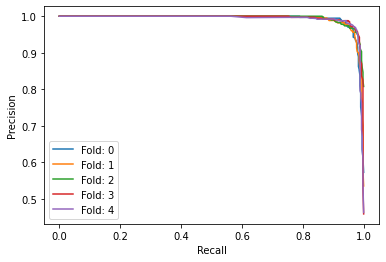

In [107]:
efm = Ethereum_Fraud_Model()
df = efm.df.drop(efm.filtered_colns, axis=1)
rfm = Random_Forest_Model(df)
rfm.set_max_depth(100)
efm.add_model(rfm)
efm.run_model(model_name='RandomForest')

## Model 3. Unsupervised: GMM (by Pratik)

In [108]:
# GMM
gmm_model = GMM_Model(efm.df.drop(efm.filtered_colns, axis=1))
efm.add_model(gmm_model)
efm.run_model(model_name='GMM')

Model Name: GMM


,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,min value received,...,ERC20 max val rec,ERC20 avg val rec,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name
8141,1,0.00,5037.57,213312.12,1,10,0,10,1,0.298630,...,1670.372596,444.315306,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
9390,1,81.29,544.37,2965.73,3,5,0,5,3,0.037845,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4081,0,0.00,2394.90,201171.80,0,84,1,2,0,0.000000,...,1.015054,0.742360,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
8356,1,366.83,26.62,1499.75,3,15,0,15,3,0.002500,...,13.370000,13.370000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9355,1,0.00,790.58,51786.47,1,15,0,13,1,0.203750,...,12.203631,12.203631,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Components: 1
Final threshold: -226.262626
Test Recall Score: 1.000
Test Precision Score: 0.587
Test F1 Score: 0.740
tn, fp, fn, tp: [   0  767    0 1090]
Components: 2
Final threshold: -226.262626
Test Recall Score: 1.000
Test Precision Score: 0.587
Test F1 Score: 0.740
tn, fp, fn, tp: [   0  767    0 1090]
Components: 3


ValueError: Fitting the mixture model failed because some components have ill-defined empirical covariance (for instance caused by singleton or collapsed samples). Try to decrease the number of components, or increase reg_covar.

## Model 4. Unsupervised: DBSCAN (by Pratik)

In [ ]:
# DBSCAN Model
df = efm.data.drop(efm.filtered_colns, axis=1)
dbscan_model = DBSCAN_Model(df)
efm.add_model(dbscan_model)
efm.run_model(model_name='DBSCAN')

# 8. Model Evaluation (by Kenny)

### -------------------- Functions Delarations --------------------

In [ ]:
# Helper: compute corresponding f1-score given thresholds
def compute_f1(y_test, y_pred, thresholds):
    scores = []
    for th in thresholds:
        th_y_pred = y_pred.copy()
        
        th_y_pred[th_y_pred >= th] = 0
        th_y_pred[th_y_pred < th] = 1
        scores.append(f1_score(y_test, th_y_pred))
    return scores


def plot_ROC(y_test, y_pred, plt_config, f1=False):
    fpr, tpr, threshold = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    
    scores = []
    if f1:
        scores = compute_f1(y_test, y_pred, thresholds)

    plt.figure(figsize=plt_config['figsize'])
    plt.title('ROC for ' + plt_config['model'])
    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
    plt.plot([0,1], [0,1], 'y--')
    if f1:
        plt.plot(thresholds, scores, 'r')
    plt.ylabel('True Positive Rate / Score')
    plt.xlabel('False Positive Rate / Threshold')
    plt.legend(['ROC', 'Perfect Classifier', 'F1'])
    plt.show()


def plot_PRC(y_test, y_pred, plt_config, f1=False):
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

    scores = []
    if f1:
        scores = compute_f1(y_test, y_pred, thresholds)

    plt.figure(figsize=plt_config['figsize'])
    plt.title('PRC for ' + plt_config['model'])
    plt.plot(recall, precision, 'b')
    if f1:
        plt.plot(thresholds, scores, 'r')
    plt.ylabel('Precision / Score')
    plt.xlabel('Recall / Threshold')
    plt.legend(['PRC', 'F1'])
    plt.show()


## Metric 1. ROC w/ F1

In [ ]:
# Prepare parameters for ROC

# Uncomment the following when you have data ready

"""
# Get probablistic predictions using a trained model
probs = xgb_c.predict_proba(norm_test_f)
pred = probs[:, 1]

# Customize plot
plt_config = {
    'figsize': (12, 8),
    'model': 'XGB Classifier'
}

# Call the function with your choice of f1 plotting (in the same grapgh)
plot_ROC(y_test, pred, plt_config, f1=True)
"""

## Metric 2. PRC w/ F1

In [ ]:
# Prepare parameters for PRC

# Uncomment the following when you have data ready

"""
# Get probablistic predictions using a trained model
probs = xgb_c.predict_proba(norm_test_f)
pred = probs[:, 1]

# Customize plot
plt_config = {
    'figsize': (12, 8),
    'model': 'XGB Classifier'
}

# Call the function with your choice of f1 plotting (in the same grapgh)
plot_PRC(y_test, pred, plt_config, f1=True)
"""